In [1]:
# Imports
import os
import sys
import cmath
import math
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import pandas as pd
import sympy as sp
from sympy.utilities.lambdify import lambdify
from scipy import signal
%matplotlib inline
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
from matplotlib.ticker import LogLocator
import control

### Derive capacitor voltage

In [2]:
s,n,R_on,R,L,C,D,Dp,V_g,V,I = sp.symbols("s,n,R_on,R,L,C,D,D',V_g,V,I")

In [3]:
V = V_g * D/Dp
I = V/(R*Dp)

In [4]:
A = sp.Matrix([
    [0, -Dp/L],
    [Dp/C, -1/(R*C)]
])

In [5]:
B = sp.Matrix([
    [(V_g+V)/L, D/L],
    [-I/C, 0]
])

In [6]:
C = sp.eye(2)
E = sp.Matrix([[0, 0],[0, 0]])
I = sp.eye(2)
tf = C*(s*I-A).inv()*B+E
H = sp.Matrix(tf)

In [7]:
sp.simplify(H)

Matrix([
[    V_g*(D + (D + D')*(C*R*s + 1))/(D'*(C*L*R*s**2 + D'**2*R + L*s)), D*(C*R*s + 1)/(C*L*R*s**2 + D'**2*R + L*s)],
[V_g*(-D*L*s + D'**2*R*(D + D'))/(D'**2*(C*L*R*s**2 + D'**2*R + L*s)),        D*D'*R/(C*L*R*s**2 + D'**2*R + L*s)]])

In [8]:
sp.simplify(H[2])

V_g*(-D*L*s + D'**2*R*(D + D'))/(D'**2*(C*L*R*s**2 + D'**2*R + L*s))

### Controller Design Problem

In [9]:
system = {
    'R'  :5,
    'L'  :50e-6,
    'C'  :220e-6,
    "D"  :0.238,
    "D'" :0.762,
    "V_g" :48
}
H0 = H[0].subs(system)
H1 = H[1].subs(system)
H2 = H[2].subs(system)
H3 = H[3].subs(system)

In [10]:
H2

-0.000983735300803935*s/(5.5e-8*s**2 + 5.0e-5*s + 2.90322) + 240.0/(5.5e-8*s**2 + 5.0e-5*s + 2.90322)

In [11]:
s  = control.TransferFunction.s

In [12]:
P =  -9.837e-5*s/(5.5e-9*s**2 + 5e-6*s + 2.90322) + 240/(5.5e-9*s**2 + 5e-6*s + 2.90322)
P.dcgain()
P.zero()
P.pole()

array(82.666832)

array([ 2.43976822e+06    +0.j        , -4.54545455e+02+22970.66760562j,
       -4.54545455e+02-22970.66760562j])

array([-454.54581856+22970.66761254j, -454.54581856-22970.66761254j,
       -454.54509053+22970.6675987j , -454.54509053-22970.6675987j ])

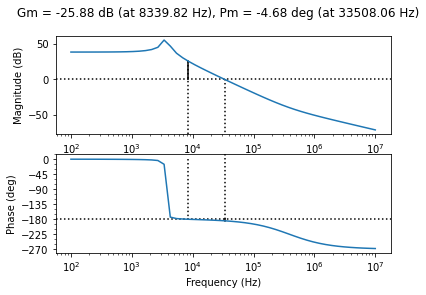

In [13]:
x,y,z = control.bode_plot(P,plot=True,dB=True,deg=True,Hz=True,margins=True)

In [14]:
s = sp.symbols("s")
P =  -9.837e-5*s/(5.5e-9*s**2 + 5e-6*s + 2.90322) + 240/(5.5e-9*s**2 + 5e-6*s + 2.90322)

In [15]:
f = np.logspace(0, 7, 10000)
w = 2*np.pi*f

In [16]:
P = lambdify(s,P,modules='numpy')
P = P(1j*w)

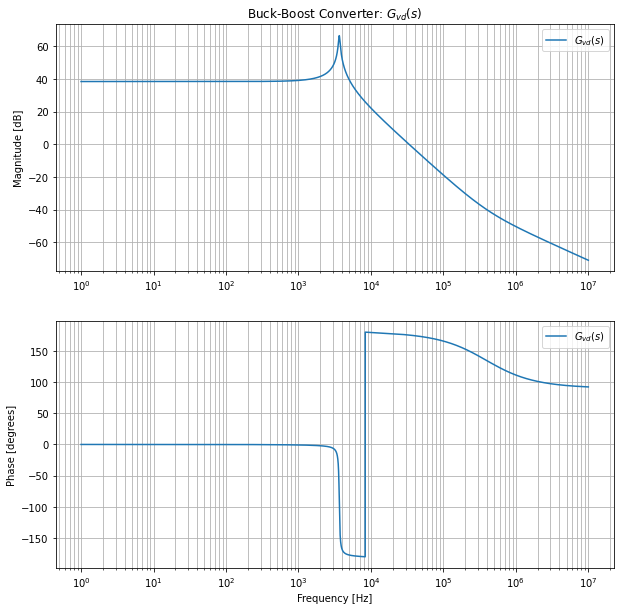

In [17]:
fig, ax = plt.subplots(2,1,figsize=(10,10))

ax[0].set_title('Buck-Boost Converter: $G_{vd}(s)$')
ax[0].semilogx(f,20*np.log10(abs(P)),label='$G_{vd}(s)$')
ax[0].set_ylabel('Magnitude [dB]')
ax[0].grid(which='both', axis='both')
ax[0].legend()

ax[1].semilogx(f,np.angle(P,deg=True),label='$G_{vd}(s)$')
ax[1].set_ylabel('Phase [degrees]')
ax[1].set_xlabel('Frequency [Hz]')
ax[1].grid(which='both', axis='both')
ax[1].legend()
plt.show();

In [18]:
C = 1/s
p = -9.837e-5*s/(5.5e-9*s**2 + 5e-6*s + 2.90322) + 240/(5.5e-9*s**2 + 5e-6*s + 2.90322)

In [19]:
L = lambdify(s,C*p,modules='numpy')
L = L(1j*w)

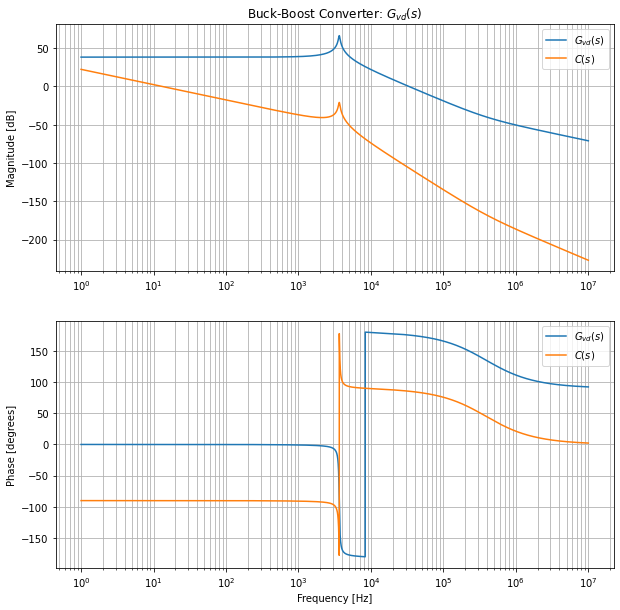

In [20]:
fig, ax = plt.subplots(2,1,figsize=(10,10))

ax[0].set_title('Buck-Boost Converter: $G_{vd}(s)$')
ax[0].semilogx(f,20*np.log10(abs(P)),label='$G_{vd}(s)$')
ax[0].semilogx(f,20*np.log10(abs(L)),label='$C(s)$')
ax[0].set_ylabel('Magnitude [dB]')
ax[0].grid(which='both', axis='both')
ax[0].legend()

ax[1].semilogx(f,np.angle(P,deg=True),label='$G_{vd}(s)$')
ax[1].semilogx(f,np.angle(L,deg=True),label='$C(s)$')
ax[1].set_ylabel('Phase [degrees]')
ax[1].set_xlabel('Frequency [Hz]')
ax[1].grid(which='both', axis='both')
ax[1].legend()
plt.show();

In [21]:
s  = control.TransferFunction.s

In [22]:
L = None
Ki = 100
C = Ki/s
p = -9.837e-5*s/(5.5e-9*s**2 + 5e-6*s + 2.90322) + 240/(5.5e-9*s**2 + 5e-6*s + 2.90322)
L = C*p
gm, pm, wg, wp = control.margin(L)
gm, pm, round(wg), round(wp)

(0.10992949331711566, -82.32904464459854, 22971, 26306)

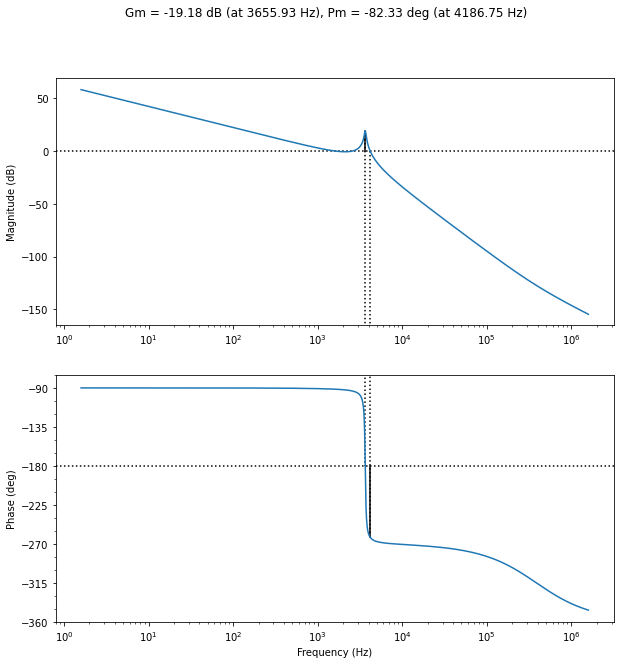

In [23]:
w = np.logspace(1,7,10000)
x,y,z = control.bode_plot(L,w,plot=True,dB=True,deg=True,Hz=True,margins=True)
fig = matplotlib.pyplot.gcf()
fig.set_size_inches(10, 10)

In [24]:
L = None
Kp = Ki/22971
C = Kp+Ki/s
L = C*p

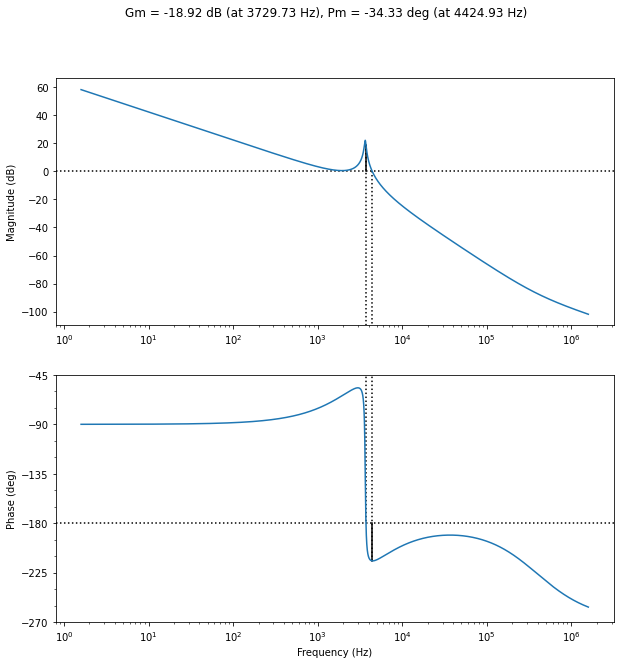

In [25]:
x,y,z = control.bode_plot(L,w,plot=True,dB=True,deg=True,Hz=True,margins=True)
fig = matplotlib.pyplot.gcf()
fig.set_size_inches(10, 10)

In [26]:
BuckBoost = pd.read_csv('BuckBoost.csv')
BuckBoostAW = pd.read_csv('BuckBoostAntiWindup.csv')

In [27]:
Time = BuckBoost['Time']
r = BuckBoost['r(t)']
y = BuckBoost['y(t)']
e = BuckBoost['e']
d = BuckBoost['d']
dsat = BuckBoost['dsat']
TimeAW = BuckBoostAW['Time']
rAW = BuckBoostAW['r(t)']
yAW = BuckBoostAW['y(t)']
eAW = BuckBoostAW['e']
dAW = BuckBoostAW['d']
dsatAW = BuckBoostAW['dsat']

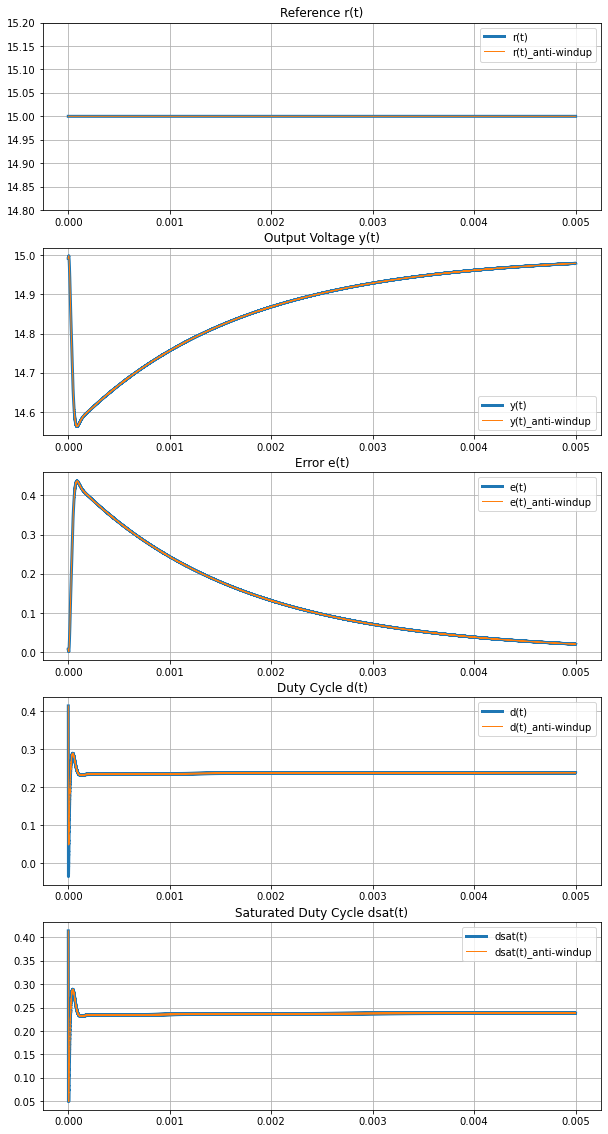

In [28]:
fig, ax = plt.subplots(5,1,figsize=(10,20))

ax[0].set_title('Reference r(t)')
ax[0].plot(Time,r,label='r(t)',linewidth=3)
ax[0].plot(TimeAW,rAW,label='r(t)_anti-windup',linewidth=1)
ax[0].set_ylim([14.8,15.2])
#ax[0].set_ylabel('Magnitude [dB]')
ax[0].grid(which='both', axis='both')
ax[0].legend()

ax[1].set_title('Output Voltage y(t)')
ax[1].plot(Time,y,label='y(t)',linewidth=3)
ax[1].plot(TimeAW,yAW,label='y(t)_anti-windup',linewidth=1)
#ax[1].set_ylim([14.8,15.2])
#ax[1].set_ylabel('Magnitude [dB]')
ax[1].grid(which='both', axis='both')
ax[1].legend()

ax[2].set_title('Error e(t)')
ax[2].plot(Time,e,label='e(t)',linewidth=3)
ax[2].plot(TimeAW,eAW,label='e(t)_anti-windup',linewidth=1)
#ax[2].set_ylim([14.8,15.2])
#ax[2].set_ylabel('Magnitude [dB]')
ax[2].grid(which='both', axis='both')
ax[2].legend()

ax[3].set_title('Duty Cycle d(t)')
ax[3].plot(Time,d,label='d(t)',linewidth=3)
ax[3].plot(TimeAW,dAW,label='d(t)_anti-windup',linewidth=1)
#ax[3].set_ylim([14.8,15.2])
#ax[3].set_ylabel('Magnitude [dB]')
ax[3].grid(which='both', axis='both')
ax[3].legend()

ax[4].set_title('Saturated Duty Cycle dsat(t)')
ax[4].plot(Time,dsat,label='dsat(t)',linewidth=3)
ax[4].plot(TimeAW,dsatAW,label='dsat(t)_anti-windup',linewidth=1)
#ax[4].set_ylim([14.8,15.2])
#ax[4].set_ylabel('Magnitude [dB]')
ax[4].grid(which='both', axis='both')
ax[4].legend();

In [62]:
s,z,T_samp,d,e = sp.symbols("s,z^-1,T_samp,d,e")

In [63]:
fc = 5000
wc = 2*sp.pi*fc
Kp = Ki/(wc)
C = Kp + Ki/s

alpha = 5000
T = 1/(100*wc)
lead = (1+alpha*T*s)/(1+T*s)

In [64]:
li = C*lead
li

(1/(100*pi) + 100/s)*(s/(200*pi) + 1)/(s/(1000000*pi) + 1)

In [81]:
s,z,T_samp,d,e,T,alpha,Kp,Ki = sp.symbols("s,z^-1,T_samp,d,e,T,alpha,Kp,Ki")

In [82]:
C = Kp + Ki/s
lead = (1+alpha*T*s)/(1+T*s)
li = C*lead

In [84]:
li

(Ki/s + Kp)*(T*alpha*s + 1)/(T*s + 1)

In [87]:
system = {
    's'  :(2/T_samp)*(1-z)/(1+z)
}
li = li.subs(system)

In [88]:
li

(Ki*T_samp*(z^-1 + 1)/(2*(1 - z^-1)) + Kp)*(2*T*alpha*(1 - z^-1)/(T_samp*(z^-1 + 1)) + 1)/(2*T*(1 - z^-1)/(T_samp*(z^-1 + 1)) + 1)

In [93]:
sp.simplify(li)

-(Ki*T_samp*(z^-1 + 1) - 2*Kp*(z^-1 - 1))*(2*T*alpha*(z^-1 - 1) - T_samp*(z^-1 + 1))/(2*(z^-1 - 1)*(2*T*(z^-1 - 1) - T_samp*(z^-1 + 1)))

In [96]:
#denominator
sp.expand(2*(z-1)*(2*T*(z-1))-T_samp*(z+1))

4*T*z^-1**2 - 8*T*z^-1 + 4*T - T_samp*z^-1 - T_samp

In [80]:
#numerator
sp.expand(-((Ki*T_samp*(z+1)-2*Kp*(z-1))*(2*T*alpha*(z-1))-T_samp*(z+1)))

-2*Ki*T*T_samp*alpha*z^-1**2 + 2*Ki*T*T_samp*alpha + 4*Kp*T*alpha*z^-1**2 - 8*Kp*T*alpha*z^-1 + 4*Kp*T*alpha + T_samp*z^-1 + T_samp